# Import Cleaned Data & Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error

In [2]:
#See part 1 for scrubbing process

df  = pd.read_csv('cleaned_df_zipcodes')
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,home_age,yrs_since_reno
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0,98178,47.5112,-122.257,1340,5650,2014,65,2020
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400,98125,47.7210,-122.319,1690,7639,2014,69,29
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0,98028,47.7379,-122.233,2720,8062,2015,87,2020
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910,98136,47.5208,-122.393,1360,5000,2014,55,2020
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0,98074,47.6168,-122.045,1800,7503,2015,33,2020


# Bucketing data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21188 entries, 0 to 21187
Data columns (total 20 columns):
price             21188 non-null float64
bedrooms          21188 non-null int64
bathrooms         21188 non-null float64
sqft_living       21188 non-null int64
sqft_lot          21188 non-null int64
floors            21188 non-null float64
waterfront        21188 non-null float64
view              21188 non-null float64
condition         21188 non-null int64
grade             21188 non-null int64
sqft_above        21188 non-null int64
sqft_basement     21188 non-null int64
zipcode           21188 non-null int64
lat               21188 non-null float64
long              21188 non-null float64
sqft_living15     21188 non-null int64
sqft_lot15        21188 non-null int64
yr_sold           21188 non-null int64
home_age          21188 non-null int64
yrs_since_reno    21188 non-null int64
dtypes: float64(7), int64(13)
memory usage: 3.2 MB


In [4]:
#Adding a new column to replace the sqft_basement
#sqft_basement data is very skewed since any house w/o a basement was assigned 0 
#(see part 2)

df.loc[df['sqft_basement'] == 0, 'has_basement'] = 0
df.loc[df['sqft_basement'] != 0, 'has_basement'] = 1

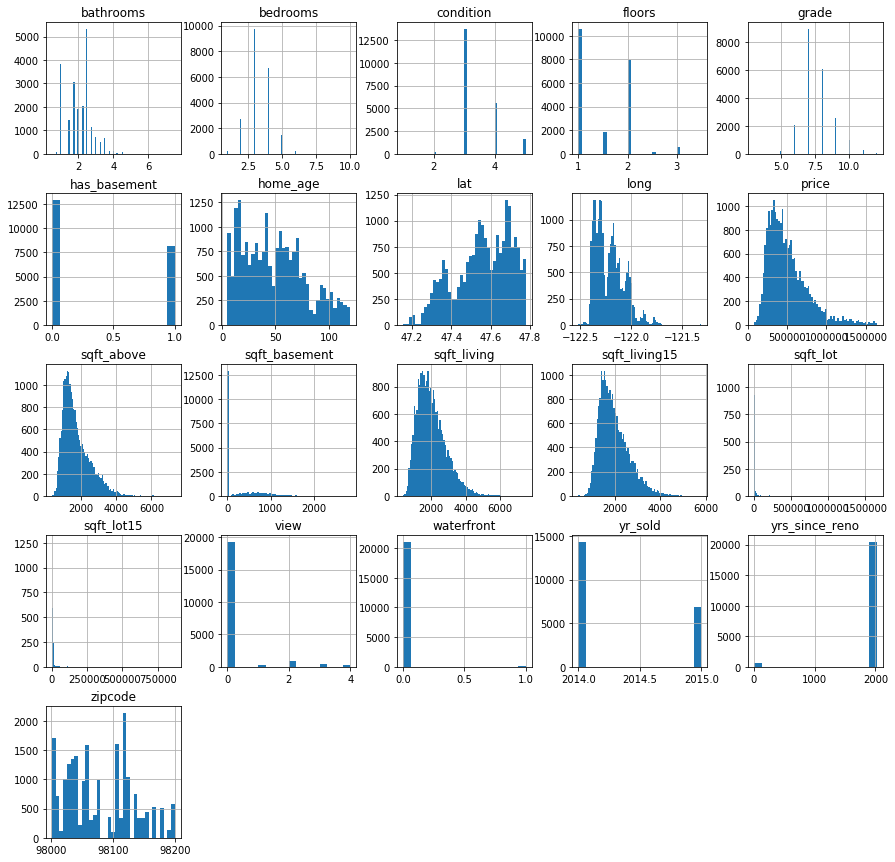

In [5]:
df.hist(bins = 'auto', figsize = (15,15));

In [6]:
#splitting continous and categorical variables
#Dropping sqft_basement

#Categorical df 

df_cat = df[['yrs_since_reno','waterfront','view','condition','grade','has_basement',
            'yr_sold','zipcode']].copy()

#Numerical df

df_num = df[['bathrooms','bedrooms','floors','home_age','price','sqft_above','sqft_living','sqft_living15',
            'sqft_lot','sqft_lot15']].copy()


# Removing outliers in df_num

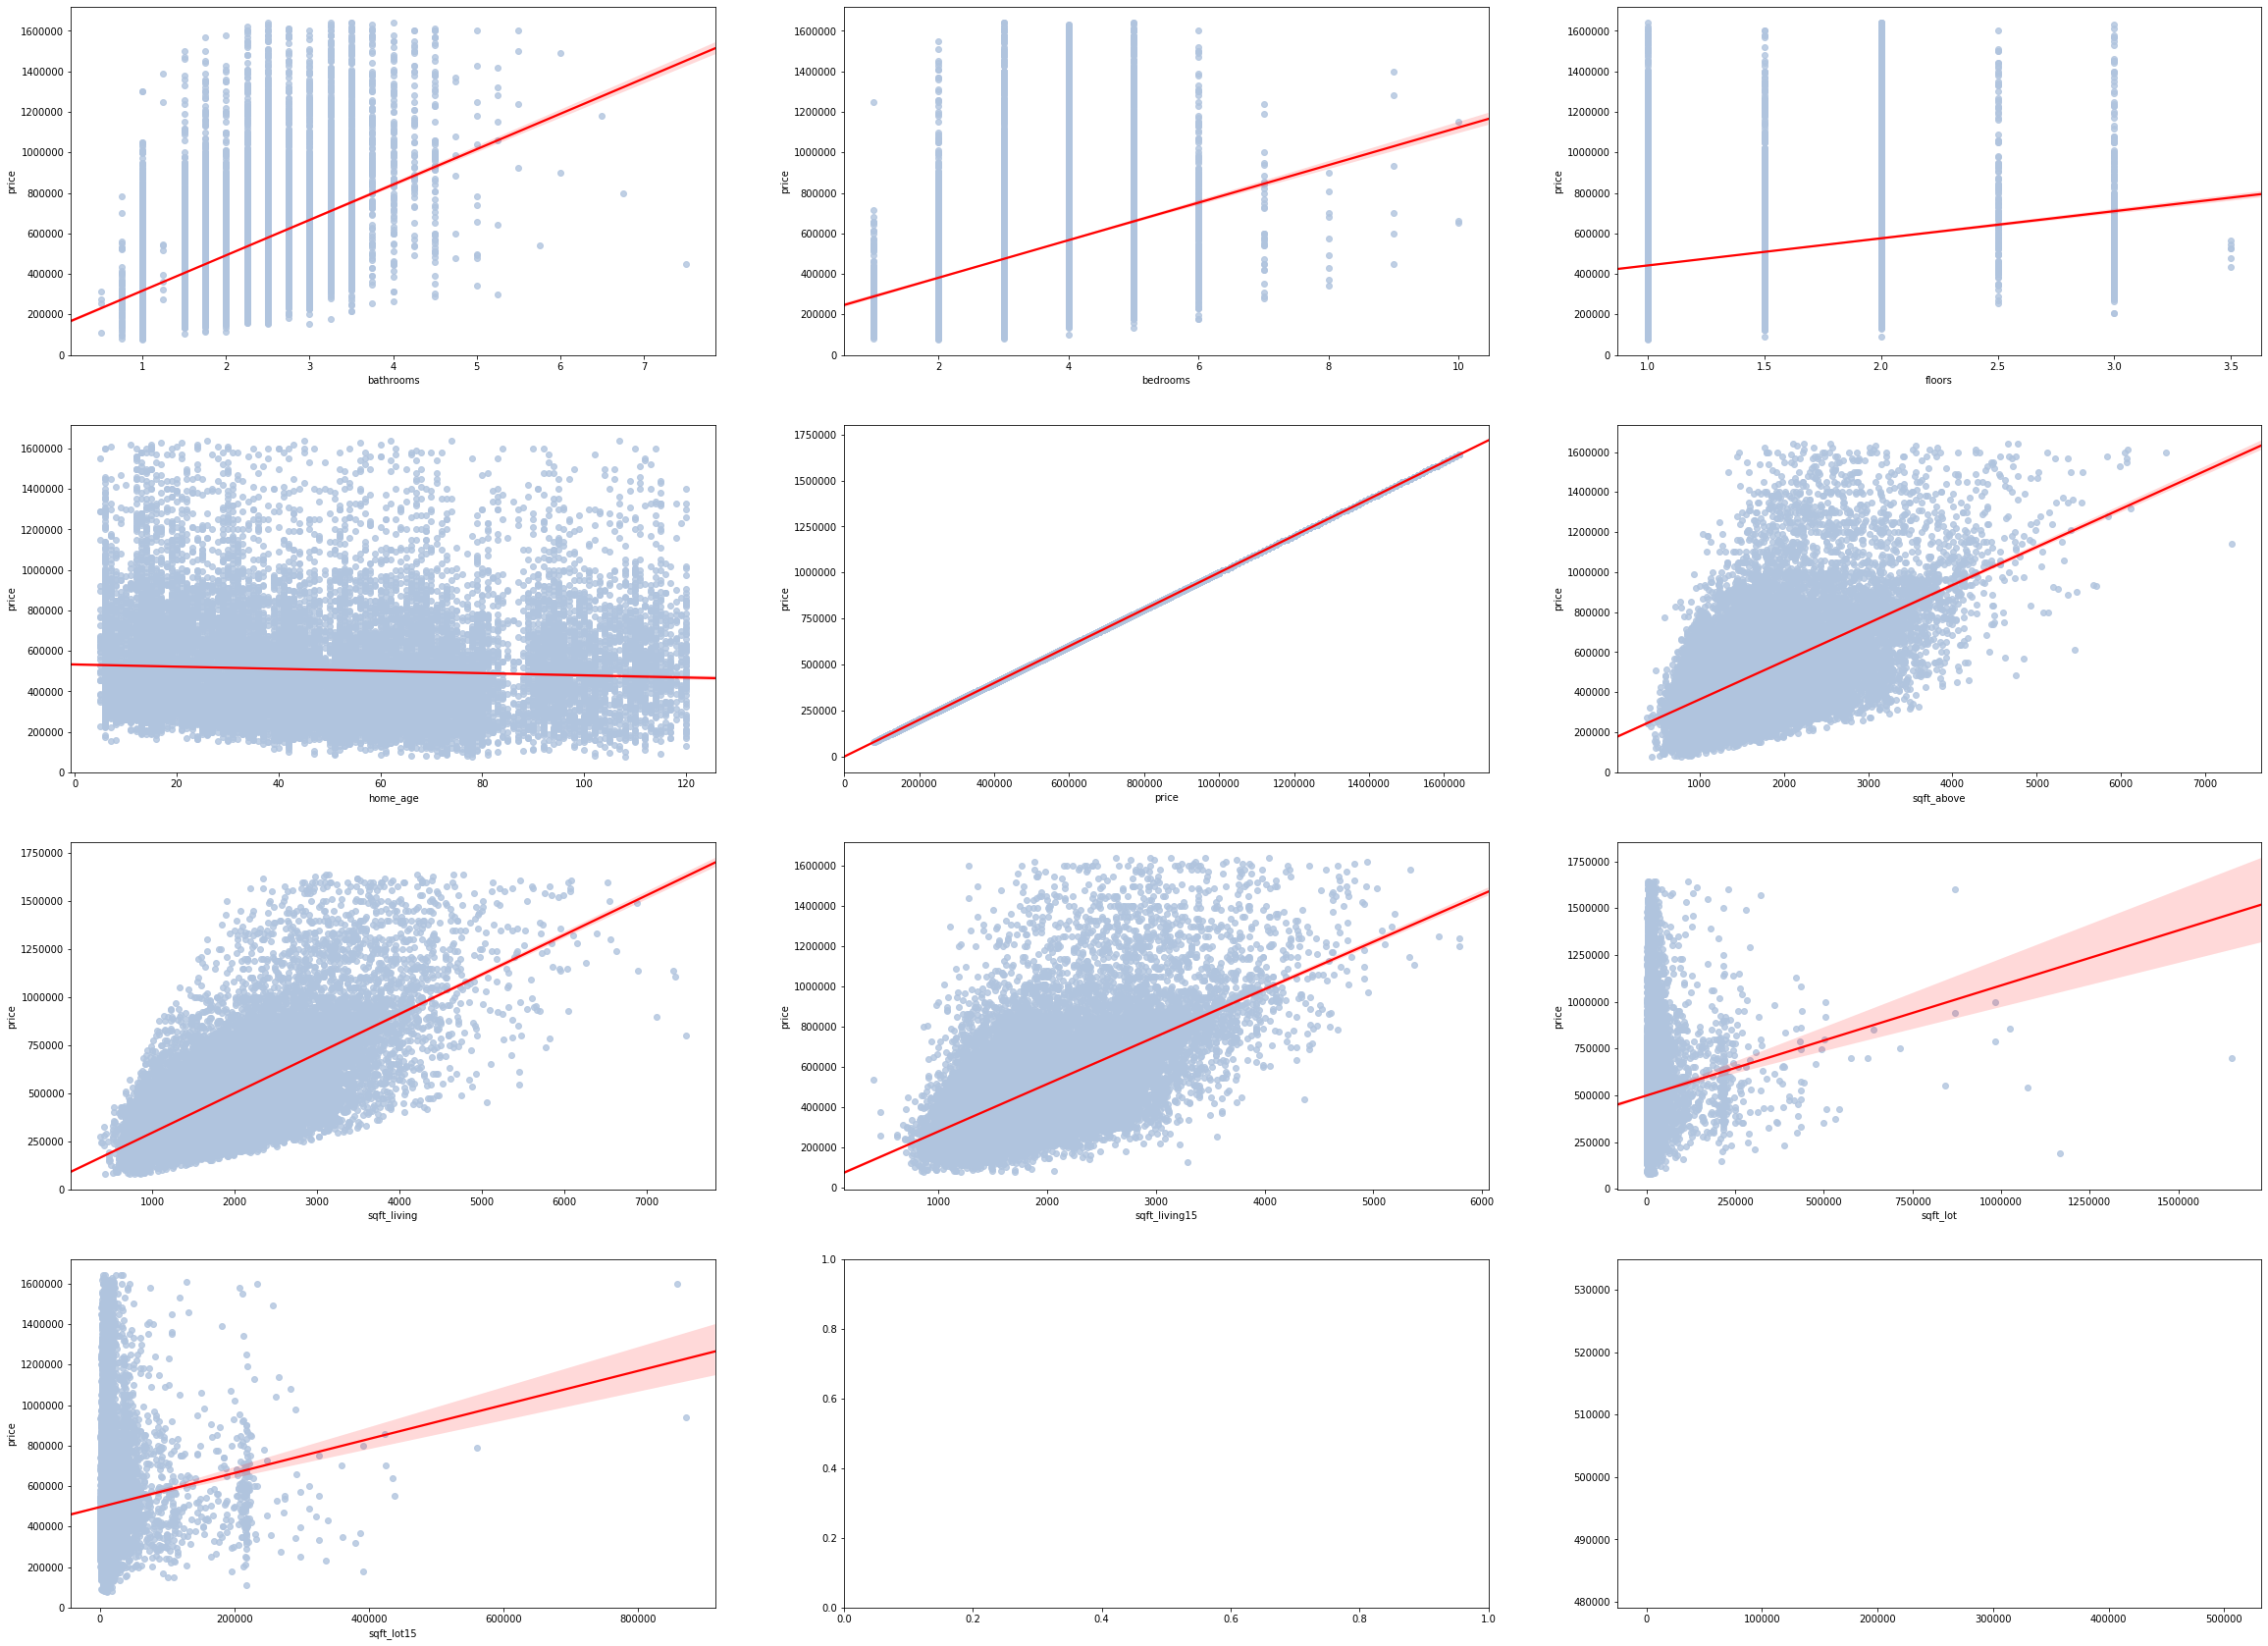

In [7]:
fig, axes = plt.subplots(4, 3,figsize=(40,30))
axes = axes.flatten()
for i, (feature, ax) in enumerate(zip(df_num, axes), 1):
    sns.regplot(data=df_num, x=feature, y='price', ax=ax,scatter_kws = {'color': 'lightsteelblue'}
                ,line_kws = {'color': 'red'})

In [8]:
#sqft_lot appears to have many outliers
#Otherwise, it is difficult to tell
#Going to leverage z-score

In [9]:
df_no_outliers = df_num[(np.abs(stats.zscore(df_num)) < 3).all(axis=1)]
df_no_outliers

,bathrooms,bedrooms,floors,home_age,price,sqft_above,sqft_living,sqft_living15,sqft_lot,sqft_lot15
0,1.00,3,1.0,65,221900.0,1180,1180,1340,5650,5650
1,2.25,3,2.0,69,538000.0,2170,2570,1690,7242,7639
2,1.00,2,1.0,87,180000.0,770,770,2720,10000,8062
3,3.00,4,1.0,55,604000.0,1050,1960,1360,5000,5000
4,2.00,3,1.0,33,510000.0,1680,1680,1800,8080,7503
...,...,...,...,...,...,...,...,...,...,...
21183,2.50,3,3.0,11,360000.0,1530,1530,1530,1131,1509
21184,2.50,4,2.0,6,400000.0,2310,2310,1830,5813,7200
21185,0.75,2,2.0,11,402101.0,1020,1020,1020,1350,2007
21186,2.50,3,2.0,16,400000.0,1600,1600,1410,2388,1287


In [10]:
#Repeating regplots
#Appear more normal

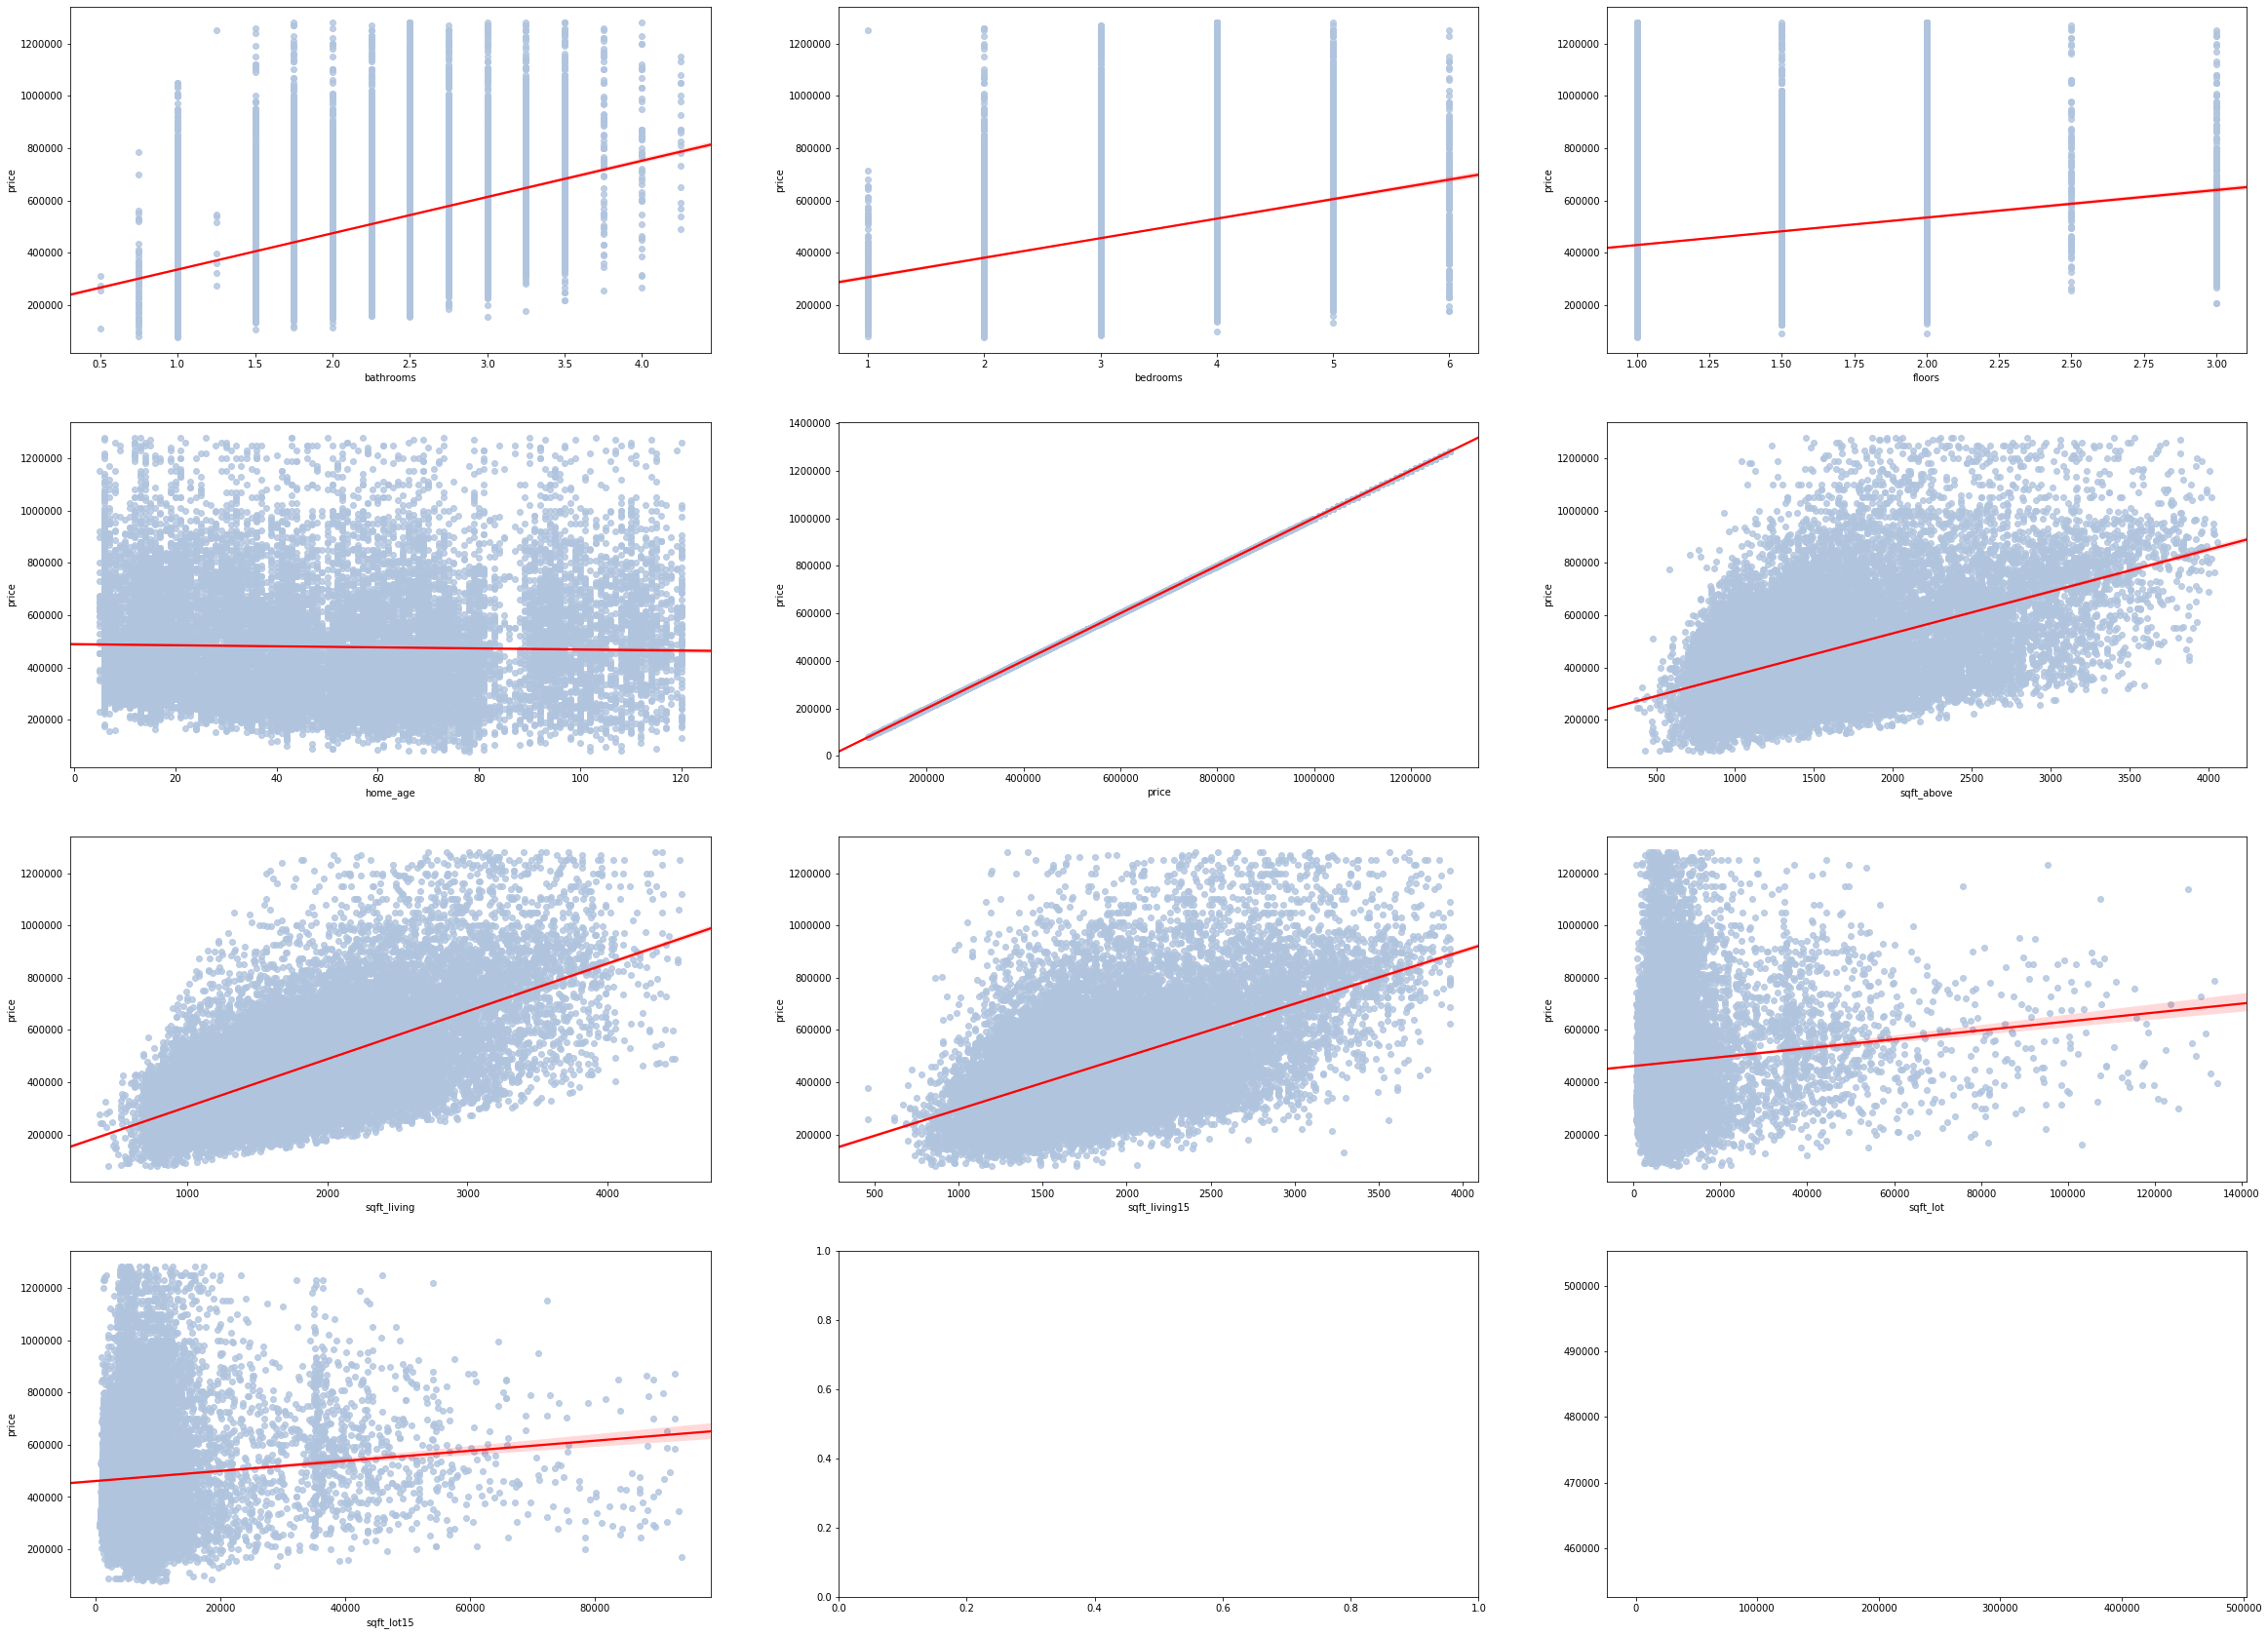

In [11]:
fig, axes = plt.subplots(4, 3,figsize=(40,30))
axes = axes.flatten()
for i, (feature, ax) in enumerate(zip(df_no_outliers, axes), 1):
    sns.regplot(data=df_no_outliers, x=feature, y='price', ax=ax,scatter_kws = {'color': 'lightsteelblue'}
                ,line_kws = {'color': 'red'})

In [12]:
#Performing simple linear regression for each variable

In [13]:
linreg = LinearRegression() 

for col in df_no_outliers.columns:
    
    x = df_no_outliers[col].values.reshape(-1, 1) 
    y = df_no_outliers['price'].values.reshape(-1, 1) 
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    print(col,"v. price")
    print('r-squared:', round(r_sq,2))
    print("")

bathrooms v. price
r-squared: 0.19

bedrooms v. price
r-squared: 0.09

floors v. price
r-squared: 0.07

home_age v. price
r-squared: 0.0

price v. price
r-squared: 1.0

sqft_above v. price
r-squared: 0.25

sqft_living v. price
r-squared: 0.37

sqft_living15 v. price
r-squared: 0.3

sqft_lot v. price
r-squared: 0.01

sqft_lot15 v. price
r-squared: 0.01



In [14]:
#sqft_living, sqft_living15, sqft_above and bathrooms are most highly correlated w/price

In [15]:
#Saving df with outliers removed

df_no_outliers = df[(np.abs(stats.zscore(df_num)) < 3).all(axis=1)]
df_no_outliers.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,home_age,yrs_since_reno,has_basement
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,...,0,98178,47.5112,-122.257,1340,5650,2014,65,2020,0.0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,400,98125,47.7210,-122.319,1690,7639,2014,69,29,1.0
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,...,0,98028,47.7379,-122.233,2720,8062,2015,87,2020,0.0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,910,98136,47.5208,-122.393,1360,5000,2014,55,2020,1.0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,...,0,98074,47.6168,-122.045,1800,7503,2015,33,2020,0.0


# Creating dummy variables

In [16]:
df_no_outliers.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,home_age,yrs_since_reno,has_basement
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,...,0,98178,47.5112,-122.257,1340,5650,2014,65,2020,0.0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,400,98125,47.7210,-122.319,1690,7639,2014,69,29,1.0
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,...,0,98028,47.7379,-122.233,2720,8062,2015,87,2020,0.0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,910,98136,47.5208,-122.393,1360,5000,2014,55,2020,1.0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,...,0,98074,47.6168,-122.045,1800,7503,2015,33,2020,0.0


In [17]:
df_clean = df_no_outliers.copy()
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21188 entries, 0 to 21187
Data columns (total 8 columns):
yrs_since_reno    21188 non-null int64
waterfront        21188 non-null float64
view              21188 non-null float64
condition         21188 non-null int64
grade             21188 non-null int64
has_basement      21188 non-null float64
yr_sold           21188 non-null int64
zipcode           21188 non-null int64
dtypes: float64(3), int64(5)
memory usage: 1.3 MB


In [18]:
#converting category columns to objects 

for column in list(df_cat.columns)[1:]:
    df_clean[column] = df_clean[column].astype(str)
    
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19942 entries, 0 to 21187
Data columns (total 21 columns):
price             19942 non-null float64
bedrooms          19942 non-null int64
bathrooms         19942 non-null float64
sqft_living       19942 non-null int64
sqft_lot          19942 non-null int64
floors            19942 non-null float64
waterfront        19942 non-null object
view              19942 non-null object
condition         19942 non-null object
grade             19942 non-null object
sqft_above        19942 non-null int64
sqft_basement     19942 non-null int64
zipcode           19942 non-null object
lat               19942 non-null float64
long              19942 non-null float64
sqft_living15     19942 non-null int64
sqft_lot15        19942 non-null int64
yr_sold           19942 non-null object
home_age          19942 non-null int64
yrs_since_reno    19942 non-null int64
has_basement      19942 non-null object
dtypes: float64(5), int64(9), object(7)
memory usage: 3

In [19]:
df_clean = pd.get_dummies(df_clean,drop_first=True)

In [20]:
#checking column names

df_clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'sqft_above', 'sqft_basement', 'lat', 'long',
       ...
       'zipcode_98155', 'zipcode_98166', 'zipcode_98168', 'zipcode_98177',
       'zipcode_98178', 'zipcode_98188', 'zipcode_98198', 'zipcode_98199',
       'yr_sold_2015', 'has_basement_1.0'],
      dtype='object', length=102)

In [21]:
#removing spaces from column names

df_clean.columns = df_clean.columns.str.replace(' ', '_')

In [22]:
#removing periods from column names

df_clean.columns = df_clean.columns.str.replace('.', '_')

In [23]:
df_clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'sqft_above', 'sqft_basement', 'lat', 'long',
       ...
       'zipcode_98155', 'zipcode_98166', 'zipcode_98168', 'zipcode_98177',
       'zipcode_98178', 'zipcode_98188', 'zipcode_98198', 'zipcode_98199',
       'yr_sold_2015', 'has_basement_1_0'],
      dtype='object', length=102)

# Train-Test Split

In [24]:
# Import
from sklearn.model_selection import train_test_split

In [25]:
# Defining the problem
y = df_clean.price
X = df_clean.drop('price',axis=1)

In [26]:
#split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
#Merging for modeling

train_df = X_train.copy()
train_df['price'] = y_train
train_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long,sqft_living15,...,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,yr_sold_2015,has_basement_1_0,price
15489,4,2.5,2150,5397,2.0,2150,0,47.4644,-122.151,2260,...,0,0,0,0,0,0,0,0,0,400000.0
20615,3,2.5,1509,1114,3.0,1509,0,47.7049,-122.340,1509,...,0,0,0,0,0,0,0,1,0,420000.0
2128,2,1.0,1088,8453,1.0,1088,0,47.2685,-122.231,1088,...,0,0,0,0,0,0,0,1,0,238000.0
12438,3,2.5,1740,6992,2.0,1740,0,47.3574,-122.158,1260,...,0,0,0,0,0,0,0,0,0,261500.0
6282,3,1.0,1250,8314,1.0,1250,0,47.4522,-122.178,1188,...,0,0,0,0,0,0,0,1,0,144000.0


# Baseline Model

In [28]:
outcome = 'price'
x_cols = list(X_train.columns)

In [29]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

In [30]:
model = ols(formula=formula, data=train_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     840.4
Date:                Sun, 25 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:26:07   Log-Likelihood:            -2.0407e+05
No. Observations:               15953   AIC:                         4.083e+05
Df Residuals:                   15852   BIC:                         4.091e+05
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1.338e+07   4.06e+06     -3.299      0.001   -2.13e+07   -5.43e+06
bedrooms         -2094.7085   1094.244     -1.914      0.056   -4239.550      50.133
bathrooms         1.853e+04   1780.393     10.409      0.000     1.5e+04     2.2e+04
sqft_living         60.3124      1.531     39.403      0.000      57.312      63.313
sqft_lot             1.0563      0.104     10.133      0.000       0.852       1.261
floors           -1.706e+04   2077.768     -8.211      0.000   -2.11e+04    -1.3e+04
sqft_above          55.1740      1.796     30.718      0.000      51.653      58.695
sqft_basement        5.1383      2.403      2.138      0.033       0.428       9.849
lat               7.353e+04   4.18e+04      1.759      0.079   -8430.517    1.55e+05
long             -8.146e+04   2.99e+04     -2.721      0.007    -1.4e+05   -2.28e+04
sqft_living15       29.2773      2.087     14.030      0.000      25.187      33.368
sqft_lot15          -0.6540      0.139     -4.705      0.000      -0.926      -0.382
home_age           433.4800     42.152     10.284      0.000     350.857     516.103
yrs_since_reno     -18.6973      2.114     -8.846      0.000     -22.840     -14.555
waterfront_1_0    1.913e+05   1.57e+04     12.186      0.000    1.61e+05    2.22e+05
view_1_0          6.669e+04   5971.605     11.168      0.000     5.5e+04    7.84e+04
view_2_0          5.802e+04   3724.720     15.578      0.000    5.07e+04    6.53e+04
view_3_0              1e+05   5525.997     18.098      0.000    8.92e+04    1.11e+05
view_4_0          1.996e+05   9049.585     22.060      0.000    1.82e+05    2.17e+05
condition_2       7.379e+04   2.04e+04      3.613      0.000    3.38e+04    1.14e+05
condition_3       1.019e+05   1.89e+04      5.401      0.000    6.49e+04    1.39e+05
condition_4       1.239e+05   1.89e+04      6.564      0.000    8.69e+04    1.61e+05
condition_5       1.603e+05    1.9e+04      8.439      0.000    1.23e+05    1.97e+05
grade_11          7.569e+04   1.08e+04      7.032      0.000    5.46e+04    9.68e+04
grade_3          -8.029e+04   8.78e+04     -0.915      0.360   -2.52e+05    9.18e+04
grade_4          -1.907e+05   1.97e+04     -9.691      0.000   -2.29e+05   -1.52e+05
grade_5          -2.024e+05   8748.225    -23.131      0.000    -2.2e+05   -1.85e+05
grade_6          -1.974e+05   5849.240    -33.745      0.000   -2.09e+05   -1.86e+05
grade_7          -1.743e+05   4947.145    -35.237      0.000   -1.84e+05   -1.65e+05
grade_8          -1.348e+05   4474.741    -30.121      0.000   -1.44e+05   -1.26e+05
grade_9          -5.992e+04   4377.349    -13.689      0.000   -6.85e+04   -5.13e+04
zipcode_98002     9514.7253   9042.722      1.052      0.293   -8210.038    2.72e+04
zipcode_98003    -5107.0320   7933.422     -0.644      0.520   -2.07e+04    1.04e+04
zipcode_98004     5.128

In [31]:
linreg = LinearRegression() 
linreg.fit(X_train, y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [32]:
train_mse = mean_squared_error(y_train, y_hat_train) 
test_mse = mean_squared_error(y_test, y_hat_test) 
print('Train Mean Squarred Error:', train_mse) 
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 7558515277.672846
Test Mean Squarred Error: 7640651752.450417


In [33]:
test_mse-train_mse #large difference in RMSEs

82136474.77757072

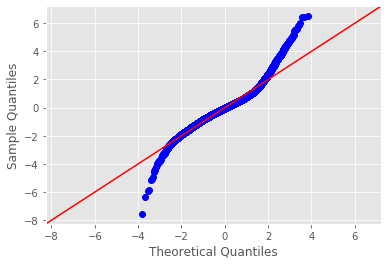

In [34]:
#Somewhat skewed distribution of residuals

plt.style.use('ggplot')

resid = model.resid

fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True)

In [35]:
#R-sq is low at 0.753 (adj is 0.752)
#Multiple variables with a p-value greater than 0.05

print(("number of features w/p-value > 0.05: ") + str(len(model.pvalues[1:][model.pvalues>0.05])))
print(("total number of features: ") + str(len(x_cols)))

number of features w/p-value > 0.05: 12
total number of features: 101


# train_df corr

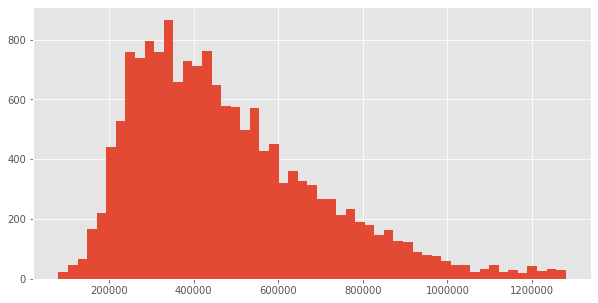

In [36]:
train_df.price.hist(bins = 'auto', figsize = (10,5));

In [37]:
train_df['price'] = train_df['price'].map(lambda x: np.log(x))

In [38]:
outcome = 'price'
x_cols = list(train_df.columns)
x_cols.remove('price')

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

model = ols(formula=formula, data=train_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     941.4
Date:                Sun, 25 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:26:08   Log-Likelihood:                 5429.2
No. Observations:               15953   AIC:                        -1.066e+04
Df Residuals:                   15852   BIC:                            -9881.
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -53.9326      8.032     -6.715      0.000     -69.676     -38.190
bedrooms            -0.0023      0.002     -1.056      0.291      -0.007       0.002
bathrooms            0.0444      0.004     12.593      0.000       0.037       0.051
sqft_living          0.0001   3.03e-06     36.518      0.000       0.000       0.000
sqft_lot           2.53e-06   2.06e-07     12.257      0.000    2.13e-06    2.93e-06
floors              -0.0315      0.004     -7.655      0.000      -0.040      -0.023
sqft_above           0.0001   3.56e-06     33.881      0.000       0.000       0.000
sqft_basement     -9.82e-06   4.76e-06     -2.063      0.039   -1.91e-05   -4.91e-07
lat                  0.4556      0.083      5.502      0.000       0.293       0.618
long                -0.3607      0.059     -6.084      0.000      -0.477      -0.244
sqft_living15     8.196e-05   4.13e-06     19.834      0.000    7.39e-05    9.01e-05
sqft_lot15       -1.001e-06   2.75e-07     -3.635      0.000   -1.54e-06   -4.61e-07
home_age             0.0007   8.35e-05      8.959      0.000       0.001       0.001
yrs_since_reno   -2.765e-05   4.19e-06     -6.606      0.000   -3.59e-05   -1.94e-05
waterfront_1_0       0.4287      0.031     13.788      0.000       0.368       0.490
view_1_0             0.1043      0.012      8.818      0.000       0.081       0.127
view_2_0             0.0954      0.007     12.936      0.000       0.081       0.110
view_3_0             0.1527      0.011     13.957      0.000       0.131       0.174
view_4_0             0.2536      0.018     14.148      0.000       0.218       0.289
condition_2          0.1573      0.040      3.890      0.000       0.078       0.237
condition_3          0.3042      0.037      8.146      0.000       0.231       0.377
condition_4          0.3520      0.037      9.419      0.000       0.279       0.425
condition_5          0.4160      0.038     11.061      0.000       0.342       0.490
grade_11             0.0429      0.021      2.013      0.044       0.001       0.085
grade_3              0.0059      0.174      0.034      0.973      -0.335       0.347
grade_4             -0.4905      0.039    -12.585      0.000      -0.567      -0.414
grade_5             -0.4158      0.017    -24.001      0.000      -0.450      -0.382
grade_6             -0.3134      0.012    -27.055      0.000      -0.336      -0.291
grade_7             -0.1975      0.010    -20.156      0.000      -0.217      -0.178
grade_8             -0.1093      0.009    -12.334      0.000      -0.127      -0.092
grade_9             -0.0255      0.009     -2.941      0.003      -0.042      -0.009
zipcode_98002       -0.0059      0.018     -0.328      0.743      -0.041       0.029
zipcode_98003       -0.0082      0.016     -0.525      0.600      -0.039       0.023
zipcode_98004        0.

In [39]:
y_test

15039    470000.0
17874    535000.0
15356    342500.0
14780    690000.0
3454     570000.0
           ...   
2662     780000.0
20575    857326.0
1453     640000.0
14026    540000.0
17527    430000.0
Name: price, Length: 3989, dtype: float64

In [40]:
X_train = train_df.drop('price',axis=1)
y_train = train_df.price

X_test = X_test[x_cols]
y_test = y_test.copy()
y_test = y_test.map(lambda x: np.log(x))


linreg = LinearRegression() 
linreg.fit(X_train, y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train) 
test_mse = mean_squared_error(y_test, y_hat_test) 
print('Train Mean Squarred Error:', train_mse) 
print('Test Mean Squarred Error:', test_mse)

test_mse-train_mse

Train Mean Squarred Error: 0.029643104764495363
Test Mean Squarred Error: 0.029637754908825652


-5.349855669710413e-06

In [41]:
model.pvalues.index[model.pvalues>0.05]

Index(['bedrooms', 'grade_3', 'zipcode_98002', 'zipcode_98003',
       'zipcode_98168', 'zipcode_98188', 'zipcode_98198'],
      dtype='object')

In [42]:
drop_high_p_values = ['bedrooms', 'grade_3', 'zipcode_98002', 'zipcode_98003',
       'zipcode_98168', 'zipcode_98188', 'zipcode_98198']

In [43]:
new_df = train_df.drop(drop_high_p_values,axis=1)

In [44]:
outcome = 'price'
x_cols = list(new_df.columns)
x_cols.remove('price')

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

model = ols(formula=formula, data=train_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     1012.
Date:                Sun, 25 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:26:09   Log-Likelihood:                 5426.9
No. Observations:               15953   AIC:                        -1.067e+04
Df Residuals:                   15859   BIC:                            -9944.
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -52.8847      6.912     -7.651      0.000     -66.433     -39.336
bathrooms            0.0438      0.003     12.602      0.000       0.037       0.051
sqft_living          0.0001   2.81e-06     38.962      0.000       0.000       0.000
sqft_lot          2.531e-06   2.06e-07     12.268      0.000    2.13e-06    2.94e-06
floors              -0.0316      0.004     -7.693      0.000      -0.040      -0.024
sqft_above           0.0001   3.52e-06     34.099      0.000       0.000       0.000
sqft_basement    -1.041e-05   4.72e-06     -2.206      0.027   -1.97e-05   -1.16e-06
lat                  0.4507      0.054      8.295      0.000       0.344       0.557
long                -0.3540      0.056     -6.323      0.000      -0.464      -0.244
sqft_living15     8.217e-05   4.13e-06     19.915      0.000    7.41e-05    9.03e-05
sqft_lot15       -9.969e-07   2.75e-07     -3.626      0.000   -1.54e-06   -4.58e-07
home_age             0.0007   8.29e-05      8.887      0.000       0.001       0.001
yrs_since_reno   -2.787e-05   4.18e-06     -6.669      0.000   -3.61e-05   -1.97e-05
waterfront_1_0       0.4296      0.031     13.843      0.000       0.369       0.490
view_1_0             0.1047      0.012      8.869      0.000       0.082       0.128
view_2_0             0.0957      0.007     12.992      0.000       0.081       0.110
view_3_0             0.1536      0.011     14.071      0.000       0.132       0.175
view_4_0             0.2543      0.018     14.208      0.000       0.219       0.289
condition_2          0.1569      0.040      3.879      0.000       0.078       0.236
condition_3          0.3042      0.037      8.148      0.000       0.231       0.377
condition_4          0.3519      0.037      9.419      0.000       0.279       0.425
condition_5          0.4160      0.038     11.064      0.000       0.342       0.490
grade_11             0.0433      0.021      2.031      0.042       0.002       0.085
grade_4             -0.4898      0.039    -12.578      0.000      -0.566      -0.414
grade_5             -0.4165      0.017    -24.115      0.000      -0.450      -0.383
grade_6             -0.3150      0.011    -27.453      0.000      -0.337      -0.292
grade_7             -0.1988      0.010    -20.616      0.000      -0.218      -0.180
grade_8             -0.1104      0.009    -12.597      0.000      -0.128      -0.093
grade_9             -0.0262      0.009     -3.039      0.002      -0.043      -0.009
zipcode_98004        0.9260      0.022     42.596      0.000       0.883       0.969
zipcode_98005        0.6319      0.023     27.797      0.000       0.587       0.676
zipcode_98006        0.5638      0.018     31.624      0.000       0.529       0.599
zipcode_98007        0.5559      0.024     22.869      0.000       0.508       0.604
zipcode_98008        0.

In [45]:
X_train = new_df.drop('price',axis=1)
y_train = new_df.price

X_test = X_test[x_cols]
y_test = y_test.copy()


linreg = LinearRegression() 
linreg.fit(X_train, y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train) 
test_mse = mean_squared_error(y_test, y_hat_test) 
print('Train Mean Squarred Error:', train_mse) 
print('Test Mean Squarred Error:', test_mse)

test_mse-train_mse

Train Mean Squarred Error: 0.02965152242855003
Test Mean Squarred Error: 0.02964682719373891


-4.695234811117471e-06

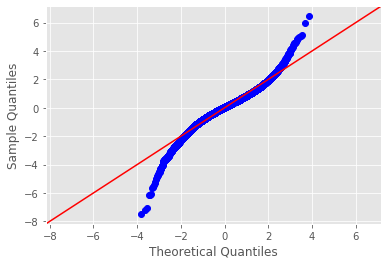

In [46]:
#Somewhat skewed distribution of residuals

plt.style.use('ggplot')

resid = model.resid

fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True)

In [47]:
corr = new_df.corr()
corr = corr[(corr.abs())>0.7]
corr

,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98177,zipcode_98178,zipcode_98199,yr_sold_2015,has_basement_1_0,price
bathrooms,1.000000,0.705146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sqft_living,0.705146,1.000000,NaN,NaN,0.838618,NaN,NaN,NaN,0.734581,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sqft_lot,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.820792,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
floors,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sqft_above,NaN,0.838618,NaN,NaN,1.000000,NaN,NaN,NaN,0.706569,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zipcode_98178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
zipcode_98199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
yr_sold_2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
has_basement_1_0,NaN,NaN,NaN,NaN,NaN,0.839841,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [48]:
corr.index[corr['bathrooms']>0]

Index(['bathrooms', 'sqft_living'], dtype='object')

In [49]:
#strong correlation between these vars. multicolinerity?

for col in corr.columns:
    if len(list(corr.index[corr[col]>0]))>1:
        print("Column: " + col)
        for x in list(corr.index[corr[col]>0]):
            if x != col:
                print (x)
        print("")
    else:
        pass

Column: bathrooms
sqft_living

Column: sqft_living
bathrooms
sqft_above
sqft_living15

Column: sqft_lot
sqft_lot15

Column: sqft_above
sqft_living
sqft_living15

Column: sqft_basement
has_basement_1_0

Column: sqft_living15
sqft_living
sqft_above

Column: sqft_lot15
sqft_lot

Column: has_basement_1_0
sqft_basement



In [50]:
#drop 'bathrooms', 'sqft_above', 'sqft_living15', 
    #'sqft_lot15','sqft_basement'

In [51]:
remove_col = ['bathrooms', 'sqft_above', 'sqft_living15', 'sqft_lot15','sqft_basement']

In [52]:
new_df_2 = new_df.drop(remove_col,axis=1)

In [53]:
outcome = 'price'
x_cols = list(new_df_2.columns)
x_cols.remove('price')

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

model = ols(formula=formula, data=train_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     989.6
Date:                Sun, 25 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:26:10   Log-Likelihood:                 4972.1
No. Observations:               15953   AIC:                            -9764.
Df Residuals:                   15863   BIC:                            -9073.
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -55.5737      7.081     -7.848      0.000     -69.454     -41.693
sqft_living          0.0002   3.14e-06     79.554      0.000       0.000       0.000
sqft_lot          2.151e-06   1.41e-07     15.213      0.000    1.87e-06    2.43e-06
floors              -0.0046      0.004     -1.178      0.239      -0.012       0.003
lat                  0.3960      0.056      7.089      0.000       0.287       0.505
long                -0.3989      0.057     -6.958      0.000      -0.511      -0.287
home_age             0.0005   8.12e-05      6.653      0.000       0.000       0.001
yrs_since_reno   -2.593e-05   4.26e-06     -6.086      0.000   -3.43e-05   -1.76e-05
waterfront_1_0       0.4175      0.032     13.092      0.000       0.355       0.480
view_1_0             0.1248      0.012     10.334      0.000       0.101       0.149
view_2_0             0.1093      0.008     14.531      0.000       0.095       0.124
view_3_0             0.1624      0.011     14.578      0.000       0.141       0.184
view_4_0             0.2716      0.018     14.848      0.000       0.236       0.307
condition_2          0.1465      0.042      3.523      0.000       0.065       0.228
condition_3          0.2883      0.038      7.509      0.000       0.213       0.364
condition_4          0.3286      0.038      8.553      0.000       0.253       0.404
condition_5          0.3906      0.039     10.105      0.000       0.315       0.466
grade_11             0.0730      0.022      3.334      0.001       0.030       0.116
grade_4             -0.5701      0.040    -14.278      0.000      -0.648      -0.492
grade_5             -0.4954      0.017    -28.321      0.000      -0.530      -0.461
grade_6             -0.3919      0.011    -34.217      0.000      -0.414      -0.369
grade_7             -0.2584      0.010    -26.817      0.000      -0.277      -0.240
grade_8             -0.1493      0.009    -16.881      0.000      -0.167      -0.132
grade_9             -0.0413      0.009     -4.667      0.000      -0.059      -0.024
zipcode_98004        0.9774      0.022     43.978      0.000       0.934       1.021
zipcode_98005        0.6759      0.023     29.009      0.000       0.630       0.722
zipcode_98006        0.6016      0.018     33.045      0.000       0.566       0.637
zipcode_98007        0.5881      0.025     23.567      0.000       0.539       0.637
zipcode_98008        0.5735      0.022     25.547      0.000       0.529       0.617
zipcode_98010        0.3105      0.028     11.194      0.000       0.256       0.365
zipcode_98011        0.3190      0.027     11.649      0.000       0.265       0.373
zipcode_98014        0.3143      0.041      7.728      0.000       0.235       0.394
zipcode_98019        0.2887      0.034      8.484      0.000       0.222       0.355
zipcode_98022        0.

In [54]:
X_train = new_df_2.drop('price',axis=1)
y_train = new_df_2.price

X_test = X_test[x_cols]
y_test = y_test.copy()


linreg = LinearRegression() 
linreg.fit(X_train, y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train) 
test_mse = mean_squared_error(y_test, y_hat_test) 
print('Train Mean Squarred Error:', train_mse) 
print('Test Mean Squarred Error:', test_mse)

test_mse-train_mse

Train Mean Squarred Error: 0.03139142864228637
Test Mean Squarred Error: 0.03121308256559906


-0.00017834607668730865

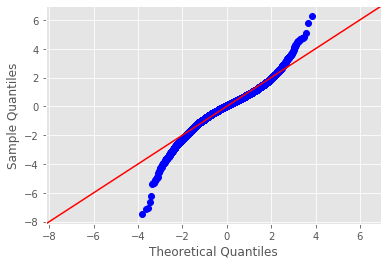

In [55]:
#Somewhat skewed distribution of residuals

plt.style.use('ggplot')

resid = model.resid

fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True)

In [56]:
new_df_2.columns

Index(['sqft_living', 'sqft_lot', 'floors', 'lat', 'long', 'home_age',
       'yrs_since_reno', 'waterfront_1_0', 'view_1_0', 'view_2_0', 'view_3_0',
       'view_4_0', 'condition_2', 'condition_3', 'condition_4', 'condition_5',
       'grade_11', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8',
       'grade_9', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023',
       'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029',
       'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033',
       'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040',
       'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053',
       'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 'zipcode_98059',
       'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074',
       'zipcode_98075', 'zip

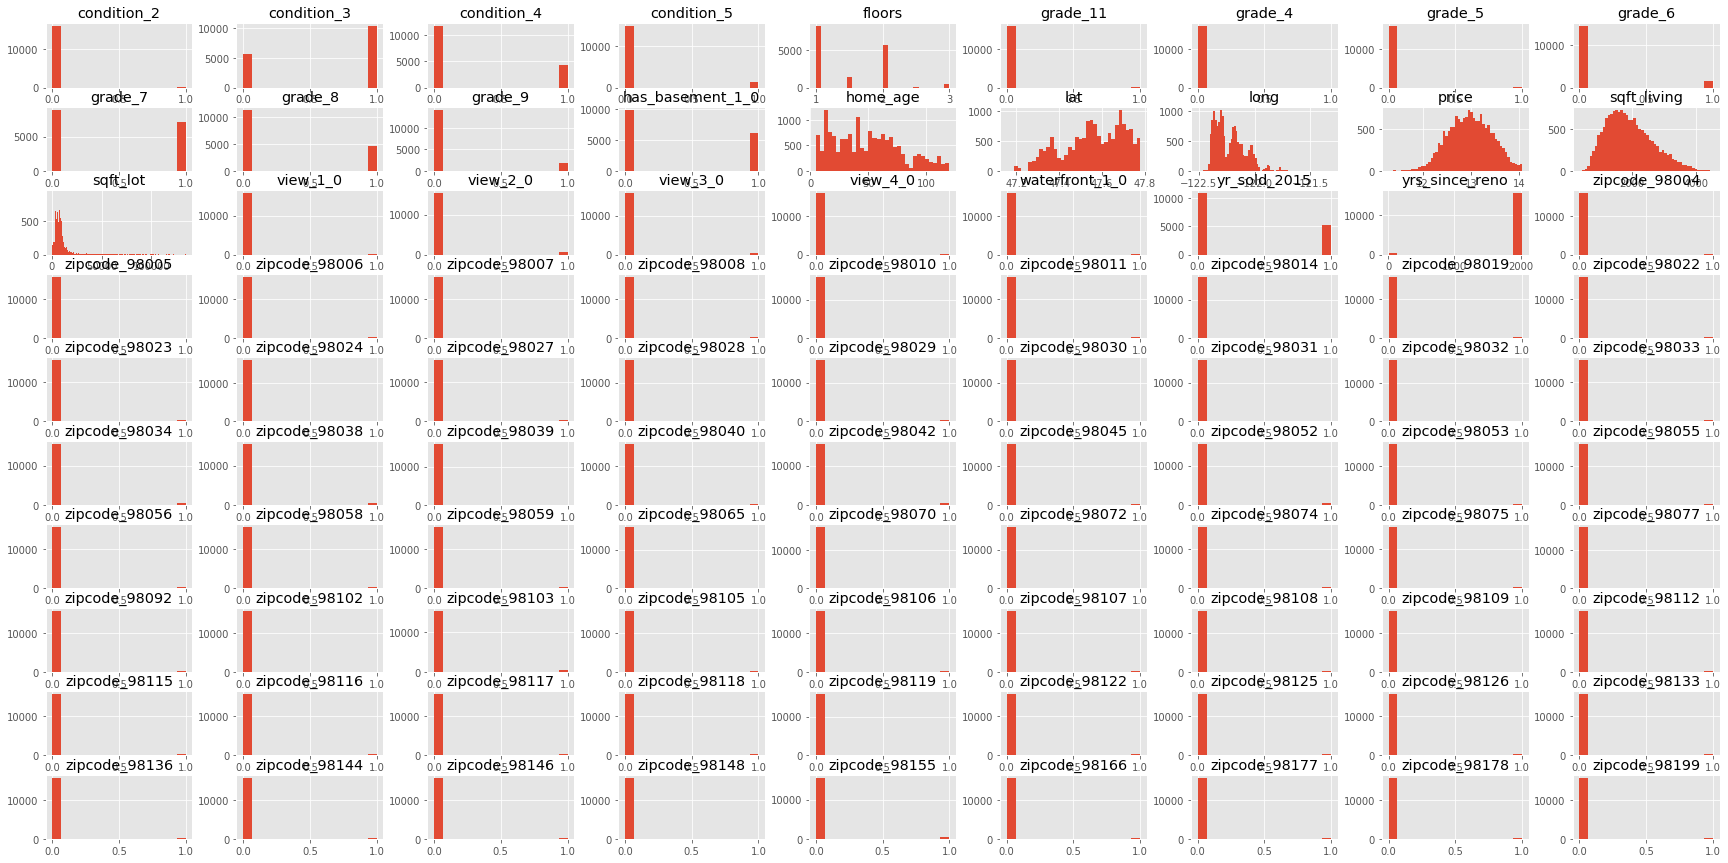

In [57]:
new_df_2.hist(bins = 'auto', figsize = (30,15));

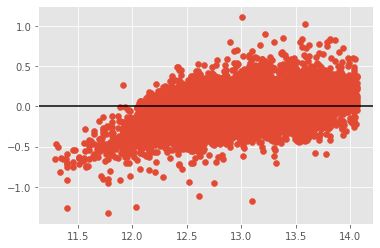

In [58]:
plt.scatter(new_df_2['price'],model.resid)
plt.axhline(0,color='black')

In [59]:
new_df_2.columns

Index(['sqft_living', 'sqft_lot', 'floors', 'lat', 'long', 'home_age',
       'yrs_since_reno', 'waterfront_1_0', 'view_1_0', 'view_2_0', 'view_3_0',
       'view_4_0', 'condition_2', 'condition_3', 'condition_4', 'condition_5',
       'grade_11', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8',
       'grade_9', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023',
       'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029',
       'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033',
       'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040',
       'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053',
       'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 'zipcode_98059',
       'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074',
       'zipcode_98075', 'zip

In [60]:
new_df_2['sqft_living'] = new_df_2['sqft_living'].map(lambda x: np.log(x))
new_df_2['sqft_lot'] = new_df_2['sqft_lot'].map(lambda x: np.log(x))
new_df_2['home_age'] = new_df_2['home_age'].map(lambda x: np.log(x))
new_df_2.drop(['lat','long','floors'],axis=1,inplace=True)

In [61]:
outcome = 'price'
x_cols = list(new_df_2.columns)
x_cols.remove('price')

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

model = ols(formula=formula, data=train_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     1015.
Date:                Sun, 25 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:26:20   Log-Likelihood:                 4912.4
No. Observations:               15953   AIC:                            -9651.
Df Residuals:                   15866   BIC:                            -8983.
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.9601      0.042    284.089      0.000      11.878      12.043
sqft_living          0.0002   3.03e-06     81.654      0.000       0.000       0.000
sqft_lot          2.034e-06   1.41e-07     14.457      0.000    1.76e-06    2.31e-06
home_age             0.0006    7.4e-05      8.689      0.000       0.000       0.001
yrs_since_reno   -2.442e-05   4.26e-06     -5.736      0.000   -3.28e-05   -1.61e-05
waterfront_1_0       0.4191      0.032     13.100      0.000       0.356       0.482
view_1_0             0.1267      0.012     10.455      0.000       0.103       0.150
view_2_0             0.1098      0.008     14.547      0.000       0.095       0.125
view_3_0             0.1649      0.011     14.755      0.000       0.143       0.187
view_4_0             0.2745      0.018     14.956      0.000       0.239       0.310
condition_2          0.1451      0.042      3.478      0.001       0.063       0.227
condition_3          0.2871      0.039      7.450      0.000       0.212       0.363
condition_4          0.3250      0.039      8.429      0.000       0.249       0.401
condition_5          0.3868      0.039      9.971      0.000       0.311       0.463
grade_11             0.0743      0.022      3.383      0.001       0.031       0.117
grade_4             -0.5751      0.040    -14.353      0.000      -0.654      -0.497
grade_5             -0.5012      0.018    -28.585      0.000      -0.536      -0.467
grade_6             -0.3926      0.011    -34.183      0.000      -0.415      -0.370
grade_7             -0.2598      0.010    -26.890      0.000      -0.279      -0.241
grade_8             -0.1502      0.009    -16.921      0.000      -0.168      -0.133
grade_9             -0.0420      0.009     -4.730      0.000      -0.059      -0.025
zipcode_98004        1.0384      0.016     63.516      0.000       1.006       1.070
zipcode_98005        0.7239      0.017     42.388      0.000       0.690       0.757
zipcode_98006        0.6219      0.011     55.207      0.000       0.600       0.644
zipcode_98007        0.6255      0.018     33.968      0.000       0.589       0.662
zipcode_98008        0.6022      0.013     45.177      0.000       0.576       0.628
zipcode_98010        0.1857      0.023      8.072      0.000       0.141       0.231
zipcode_98011        0.4378      0.015     28.967      0.000       0.408       0.467
zipcode_98014        0.2515      0.022     11.199      0.000       0.207       0.296
zipcode_98019        0.3037      0.016     19.174      0.000       0.273       0.335
zipcode_98022       -0.0160      0.016     -1.022      0.307      -0.047       0.015
zipcode_98023       -0.0521      0.010     -5.028      0.000      -0.072      -0.032
zipcode_98024        0.3806      0.029     13.034      0.000       0.323       0.438
zipcode_98027        0.

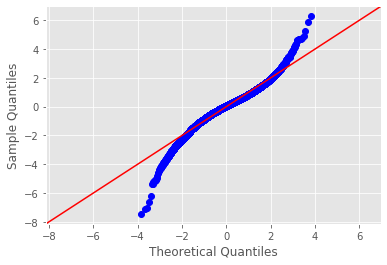

In [62]:
#Somewhat skewed distribution of residuals

plt.style.use('ggplot')

resid = model.resid

fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True)

In [63]:
limit_col = list(new_df_2.corr().price[:60].index)
limit_col.append('price')

In [64]:
new_df_3 = new_df_2[limit_col]

In [65]:
outcome = 'price'
x_cols = list(new_df_3.columns)
x_cols.remove('price')

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

model = ols(formula=formula, data=new_df_3).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     607.1
Date:                Sun, 25 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:26:21   Log-Likelihood:                -517.98
No. Observations:               15953   AIC:                             1158.
Df Residuals:                   15892   BIC:                             1626.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.2457      0.083    122.887      0.000      10.082      10.409
sqft_living        0.4482      0.008     57.899      0.000       0.433       0.463
sqft_lot          -0.0847      0.004    -23.723      0.000      -0.092      -0.078
home_age           0.1053      0.004     25.594      0.000       0.097       0.113
yrs_since_reno -3.751e-05   5.92e-06     -6.332      0.000   -4.91e-05   -2.59e-05
waterfront_1_0     0.2540      0.045      5.673      0.000       0.166       0.342
view_1_0           0.1413      0.017      8.370      0.000       0.108       0.174
view_2_0           0.1311      0.011     12.476      0.000       0.110       0.152
view_3_0           0.1520      0.016      9.738      0.000       0.121       0.183
view_4_0           0.2756      0.026     10.754      0.000       0.225       0.326
condition_2        0.0368      0.058      0.630      0.529      -0.078       0.151
condition_3        0.1624      0.054      3.014      0.003       0.057       0.268
condition_4        0.1948      0.054      3.613      0.000       0.089       0.301
condition_5        0.2756      0.054      5.076      0.000       0.169       0.382
grade_11           0.1038      0.031      3.367      0.001       0.043       0.164
grade_4           -0.7263      0.056    -12.910      0.000      -0.837      -0.616
grade_5           -0.7352      0.024    -30.382      0.000      -0.783      -0.688
grade_6           -0.6480      0.015    -42.254      0.000      -0.678      -0.618
grade_7           -0.4757      0.013    -37.118      0.000      -0.501      -0.451
grade_8           -0.2919      0.012    -24.244      0.000      -0.316      -0.268
grade_9           -0.1026      0.012     -8.285      0.000      -0.127      -0.078
zipcode_98004      0.6022      0.022     27.375      0.000       0.559       0.645
zipcode_98005      0.3095      0.023     13.383      0.000       0.264       0.355
zipcode_98006      0.1867      0.014     12.944      0.000       0.158       0.215
zipcode_98007      0.1801      0.025      7.198      0.000       0.131       0.229
zipcode_98008      0.1631      0.018      9.302      0.000       0.129       0.197
zipcode_98010     -0.0977      0.032     -3.063      0.002      -0.160      -0.035
zipcode_98011      0.0289      0.020      1.427      0.154      -0.011       0.069
zipcode_98014     -0.0094      0.031     -0.303      0.762      -0.070       0.052
zipcode_98019     -0.0315      0.021     -1.467      0.142      -0.074       0.011
zipcode_98022     -0.3529      0.021    -16.691      0.000      -0.394      -0.311
zipcode_98023     -0.4579      0.013    -34.836      0.000      -0.484      -0.432
zipcode_98024      0.1067      0.041      2.631      0.009       0.027       0.186
zipcode_98027      0.1250      0.016      7.891      0.000       0.094       0.156
zipcode_9802

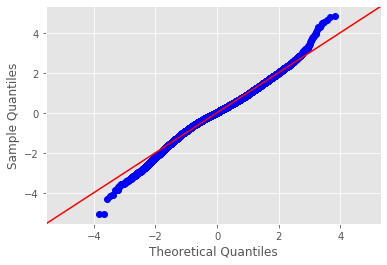

In [66]:
#Somewhat skewed distribution of residuals

plt.style.use('ggplot')

resid = model.resid

fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True)

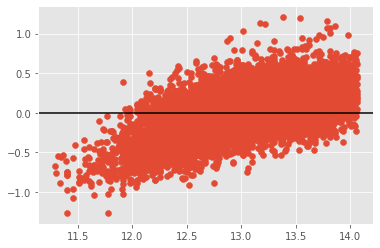

In [67]:
plt.scatter(new_df_3['price'],model.resid)
plt.axhline(0,color='black')

In [68]:
drop_cols = list(model.pvalues.index[model.pvalues>0.05])
drop_cols

['condition_2',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98028',
 'zipcode_98045']

In [69]:
new_df_4 = new_df_3.drop(drop_cols,axis=1)

In [70]:
outcome = 'price'
x_cols = list(new_df_4.columns)
x_cols.remove('price')

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

model = ols(formula=formula, data=new_df_4).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     674.4
Date:                Sun, 25 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:26:21   Log-Likelihood:                -521.18
No. Observations:               15953   AIC:                             1152.
Df Residuals:                   15898   BIC:                             1575.
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.2792      0.067    153.396      0.000      10.148      10.411
sqft_living        0.4486      0.008     58.079      0.000       0.433       0.464
sqft_lot          -0.0860      0.003    -25.255      0.000      -0.093      -0.079
home_age           0.1067      0.004     26.600      0.000       0.099       0.115
yrs_since_reno -3.726e-05   5.92e-06     -6.292      0.000   -4.89e-05   -2.57e-05
waterfront_1_0     0.2547      0.045      5.690      0.000       0.167       0.342
view_1_0           0.1414      0.017      8.382      0.000       0.108       0.174
view_2_0           0.1309      0.010     12.476      0.000       0.110       0.151
view_3_0           0.1522      0.016      9.754      0.000       0.122       0.183
view_4_0           0.2757      0.026     10.761      0.000       0.225       0.326
condition_3        0.1317      0.022      6.052      0.000       0.089       0.174
condition_4        0.1641      0.022      7.508      0.000       0.121       0.207
condition_5        0.2448      0.023     10.764      0.000       0.200       0.289
grade_11           0.1040      0.031      3.374      0.001       0.044       0.164
grade_4           -0.7290      0.056    -13.000      0.000      -0.839      -0.619
grade_5           -0.7377      0.024    -30.567      0.000      -0.785      -0.690
grade_6           -0.6493      0.015    -42.400      0.000      -0.679      -0.619
grade_7           -0.4768      0.013    -37.281      0.000      -0.502      -0.452
grade_8           -0.2928      0.012    -24.358      0.000      -0.316      -0.269
grade_9           -0.1029      0.012     -8.311      0.000      -0.127      -0.079
zipcode_98004      0.6033      0.022     27.482      0.000       0.560       0.646
zipcode_98005      0.3110      0.023     13.483      0.000       0.266       0.356
zipcode_98006      0.1878      0.014     13.102      0.000       0.160       0.216
zipcode_98007      0.1811      0.025      7.251      0.000       0.132       0.230
zipcode_98008      0.1641      0.017      9.384      0.000       0.130       0.198
zipcode_98010     -0.0950      0.032     -2.989      0.003      -0.157      -0.033
zipcode_98022     -0.3509      0.021    -16.660      0.000      -0.392      -0.310
zipcode_98023     -0.4563      0.013    -34.992      0.000      -0.482      -0.431
zipcode_98024      0.1093      0.040      2.700      0.007       0.030       0.189
zipcode_98027      0.1268      0.016      8.069      0.000       0.096       0.158
zipcode_98029      0.1250      0.016      7.608      0.000       0.093       0.157
zipcode_98030     -0.3468      0.018    -19.010      0.000      -0.383      -0.311
zipcode_98031     -0.3316      0.017    -19.114      0.000      -0.366      -0.298
zipcode_98032     -0.4768      0.025    -19.123      0.000      -0.526      -0.428
zipcode_9803

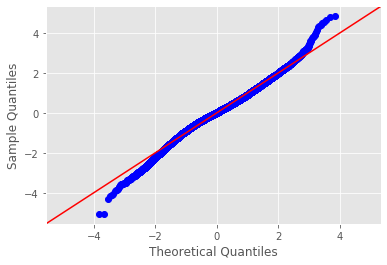

In [71]:
#Somewhat skewed distribution of residuals

plt.style.use('ggplot')

resid = model.resid

fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True)

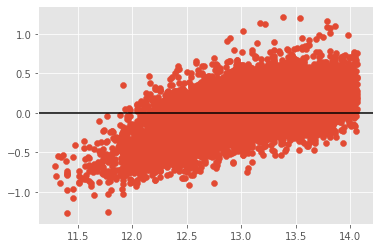

In [72]:
plt.scatter(new_df_3['price'],model.resid)
plt.axhline(0,color='black')